### Library Imports

In [4]:
import pandas as pd
import cv2
import numpy as np
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor


from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

DEFINE VARIABLES HERE

In [5]:
ANNOTATION_FILE_PATH = "../../annotations.csv"
IMAGE_DIR = 'images'
VALIDATION_RATIO = 0.1
RANDOM_STATE = 42
BATCH_SIZE = 32
LEARNING_RATE = 1e-6
WEIGHT_DECAY = 1e-4
EPOCHS = 20

### We first explore the data given in the annotations file

In [6]:
df = pd.read_csv(ANNOTATION_FILE_PATH)
train_df = df[df['Partition'] == 'train']
test_df = df[df['Partition'] == 'test']

In [7]:
df.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
0,MHIST_aaa.png,SSA,6,train
1,MHIST_aab.png,HP,0,train
2,MHIST_aac.png,SSA,5,train
3,MHIST_aae.png,HP,1,train
4,MHIST_aaf.png,SSA,5,train


### Checking the ratio of train vs test data

In [8]:
print(df['Partition'].value_counts())

Partition
train    2175
test      977
Name: count, dtype: int64


Text(0, 0.5, 'Count')

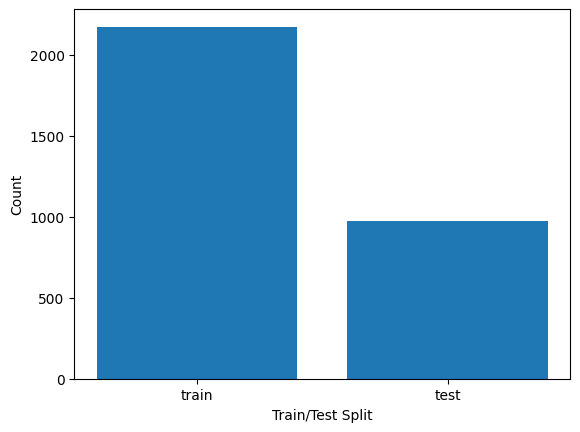

In [9]:
plt.bar( ['train', 'test'],df['Partition'].value_counts())
plt.xlabel('Train/Test Split')
plt.ylabel('Count')

In [10]:
## Sampling the data to introduce randomness
df = df.sample(frac = 1)

In [11]:
train_ssa_count = len(df[(df['Partition'] == 'train') & (df['Majority Vote Label'] == 'SSA')])
train_hp_count = len(df[(df['Partition'] == 'train') & (df['Majority Vote Label'] == 'HP')])

print(f"[INFO]: \n SSA Images in train Dataset: {train_ssa_count}\n HP Images in train Dataset: {train_hp_count}")

[INFO]: 
 SSA Images in train Dataset: 630
 HP Images in train Dataset: 1545


### Let's check the distribution of the classes "SSA" and "HP"

Text(0, 0.5, 'Count')

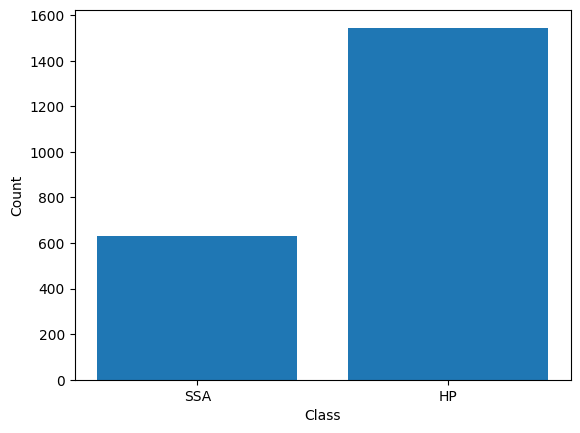

In [12]:
plt.bar(['SSA', 'HP'], [train_ssa_count, train_hp_count])
plt.xlabel('Class')
plt.ylabel('Count')

In [13]:
train_df, val_df = train_test_split(train_df, test_size = 0.2, random_state= 42)

### Data Pipeline starts

#### Step 1. We first create a Custom Dataset class, that takes the updated dataframe object, image folder and transforms ( optional)

In [14]:
class MHIST_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = torch.tensor(image, dtype=torch.float32)

        if self.img_labels.iloc[idx, 1] == 'SSA':
          label = 0
        else:
          label = 1
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_dataset = MHIST_Dataset(dataframe=train_df, img_dir= IMAGE_DIR)
val_dataset = MHIST_Dataset(dataframe=val_df, img_dir=IMAGE_DIR)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Step2. Let's verify the data and check the shape before feeding it into the pipeline, each data point here is of the form [# number of points in batch, number of channels, width, height]

In [15]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Train Feature batch shape: {train_features.size()}")
print(f"Train Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

C:\Users\deepa\AppData\Local\Temp\ipykernel_10168\615557400.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Train Feature batch shape: torch.Size([32, 3, 224, 224])
Train Labels batch shape: torch.Size([32])


In [16]:
val_features, val_labels = next(iter(val_dataloader))
print(f"Test Feature batch shape: {val_features.size()}")
print(f"Test Labels batch shape: {val_labels.size()}")

C:\Users\deepa\AppData\Local\Temp\ipykernel_10168\615557400.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Test Feature batch shape: torch.Size([32, 3, 224, 224])
Test Labels batch shape: torch.Size([32])


### CNN MODEL FROM SCRATCH

In [17]:
class CNN_Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 3, 1, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1, 1)
    self.fc1 = nn.Linear(16*56*56, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 2)

  def forward(self, X):

    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)

    X = X.view(-1, 16*56*56)

    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    X = F.log_softmax(X, dim = 1)
    return X



In [18]:
torch.manual_seed(42)
model = CNN_Model()
model

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

### Loss Function

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

### Training Starts

In [20]:
epochs = 5

train_losses = []
val_losses = []


train_correct = []
val_correct = []

for i in range(epochs):

  trn_corr = 0
  vl_corr = 0

  for b, (X_train, y_train) in tqdm(enumerate(train_dataloader)):

    #predict
    y_pred = model(X_train)

    # calculate cross entropy loss
    #print(y_pred.shape)
    loss = criterion(y_pred, y_train)

    predicted = torch.max(y_pred.data, 1)[1]
    batch_corr = (predicted == y_train).sum()

    trn_corr += batch_corr


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (b+1)%10 ==0:
      print(f"[INFO]: Epoch: {i} Batch: {b+1} Loss: {loss.item()}")

  train_losses.append(loss)
  train_correct.append(trn_corr)



  ## Testing
  with torch.no_grad():
    for b, (X_val, y_val) in enumerate(val_dataloader):
      y_val_pred = model(X_val)
      predicted = torch.max(y_val_pred.data, 1)[1]
      vl_corr += (predicted == y_val).sum()


  loss = criterion(y_val_pred, y_val)
  val_losses.append(loss)
  val_correct.append(vl_corr)

0it [00:00, ?it/s]C:\Users\deepa\AppData\Local\Temp\ipykernel_10168\615557400.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
10it [00:08,  1.15it/s]

[INFO]: Epoch: 0 Batch: 10 Loss: 0.6772338151931763


20it [00:17,  1.28it/s]

[INFO]: Epoch: 0 Batch: 20 Loss: 0.4853706657886505


30it [00:25,  1.06it/s]

[INFO]: Epoch: 0 Batch: 30 Loss: 0.7045833468437195


40it [00:35,  1.03it/s]

[INFO]: Epoch: 0 Batch: 40 Loss: 0.663965106010437


50it [00:45,  1.10it/s]

[INFO]: Epoch: 0 Batch: 50 Loss: 0.48416805267333984


55it [00:49,  1.11it/s]
10it [00:07,  1.34it/s]

[INFO]: Epoch: 1 Batch: 10 Loss: 0.6524030566215515


20it [00:15,  1.17it/s]

[INFO]: Epoch: 1 Batch: 20 Loss: 0.5670395493507385


30it [00:23,  1.26it/s]

[INFO]: Epoch: 1 Batch: 30 Loss: 0.562409520149231


40it [00:30,  1.43it/s]

[INFO]: Epoch: 1 Batch: 40 Loss: 0.623485803604126


50it [00:38,  1.38it/s]

[INFO]: Epoch: 1 Batch: 50 Loss: 0.5710099935531616


55it [00:41,  1.33it/s]
10it [00:07,  1.36it/s]

[INFO]: Epoch: 2 Batch: 10 Loss: 0.5388850569725037


20it [00:14,  1.39it/s]

[INFO]: Epoch: 2 Batch: 20 Loss: 0.4822221100330353


30it [00:21,  1.35it/s]

[INFO]: Epoch: 2 Batch: 30 Loss: 0.5672985911369324


40it [00:29,  1.30it/s]

[INFO]: Epoch: 2 Batch: 40 Loss: 0.603661835193634


50it [00:37,  1.29it/s]

[INFO]: Epoch: 2 Batch: 50 Loss: 0.5635586380958557


55it [00:40,  1.35it/s]
10it [00:07,  1.39it/s]

[INFO]: Epoch: 3 Batch: 10 Loss: 0.59501051902771


20it [00:14,  1.32it/s]

[INFO]: Epoch: 3 Batch: 20 Loss: 0.6523200273513794


30it [00:22,  1.34it/s]

[INFO]: Epoch: 3 Batch: 30 Loss: 0.5706118941307068


40it [00:29,  1.46it/s]

[INFO]: Epoch: 3 Batch: 40 Loss: 0.6240499019622803


50it [00:36,  1.45it/s]

[INFO]: Epoch: 3 Batch: 50 Loss: 0.49419882893562317


55it [00:39,  1.39it/s]
10it [00:07,  1.44it/s]

[INFO]: Epoch: 4 Batch: 10 Loss: 0.6219148635864258


20it [00:14,  1.29it/s]

[INFO]: Epoch: 4 Batch: 20 Loss: 0.5945976376533508


30it [00:21,  1.40it/s]

[INFO]: Epoch: 4 Batch: 30 Loss: 0.6540116667747498


40it [00:28,  1.48it/s]

[INFO]: Epoch: 4 Batch: 40 Loss: 0.5412687063217163


50it [00:35,  1.41it/s]

[INFO]: Epoch: 4 Batch: 50 Loss: 0.6814806461334229


55it [00:39,  1.41it/s]


In [21]:
test_dataset = MHIST_Dataset(dataframe=test_df, img_dir=IMAGE_DIR)

In [26]:
model.eval()

preds = []
original = []


with torch.no_grad():

  for i in tqdm(range(len(test_dataset))):
    pred = model(test_dataset[i][0].view(1, 3, 224, 224))
    preds.append(pred.argmax().item())
    original.append(test_dataset[i][1])

  0%|                                                                                          | 0/977 [00:00<?, ?it/s]C:\Users\deepa\AppData\Local\Temp\ipykernel_10168\615557400.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
100%|████████████████████████████████████████████████████████████████████████████████| 977/977 [00:19<00:00, 48.94it/s]


### Evaluation

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, auc

print(f"[INFO]: \nAccuracy: {accuracy_score(original, preds)} \nPrecision: {precision_score(original, preds)} \nRecall: {recall_score(original, preds)} \nF1: {f1_score(original, preds)} \n " )
print(confusion_matrix(original, preds))